In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import time as time
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, ReLU, LeakyReLU, Dropout, BatchNormalization, Concatenate, ZeroPadding2D

In [3]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, 256, 256, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [4]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   256, 256)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [5]:
train = tf.data.Dataset.list_files('../input/anime-sketch-colorization-pair/data/train/*.png')
train = train.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.shuffle(400).batch(4)
test = tf.data.Dataset.list_files('../input/anime-sketch-colorization-pair/data/val/*.png')
test = test.map(load_image_test)
test = test.batch(4)

In [6]:
inputs = Input(shape = [256, 256, 3])
outputs = inputs
outputs = Sequential({Conv2D(64, (4,4), strides=2, batch_input_shape=(None, 256, 256, 3), padding='same', use_bias=False), LeakyReLU()})(outputs)
x7 = outputs
outputs = Sequential({Conv2D(128, (4,4), strides=2, batch_input_shape=(None, 128, 128, 64), padding='same', use_bias=False), BatchNormalization(), LeakyReLU()})(outputs)
x6 = outputs
outputs = Sequential({Conv2D(256, (4,4), strides=2, batch_input_shape=(None, 64, 64, 128), padding='same', use_bias=False), BatchNormalization(), LeakyReLU()})(outputs)
x5 = outputs
outputs = Sequential({Conv2D(512, (4,4), strides=2, batch_input_shape=(None, 32, 32, 256), padding='same', use_bias=False), BatchNormalization(), LeakyReLU()})(outputs)
x4 = outputs
outputs = Sequential({Conv2D(512, (4,4), strides=2, batch_input_shape=(None, 16, 16, 512), padding='same', use_bias=False), BatchNormalization(), LeakyReLU()})(outputs)
x3 = outputs
outputs = Sequential({Conv2D(512, (4,4), strides=2, batch_input_shape=(None, 8, 8, 512), padding='same', use_bias=False), BatchNormalization(), LeakyReLU()})(outputs)
x2 = outputs
outputs = Sequential({Conv2D(512, (4,4), strdies=2, batch_input_shape=(None, 4, 4, 512), padding='same', use_bias=False), BatchNormalization(), LeakyReLU()})(outputs)
x1 = outputs
outputs = Sequential({Conv2D(512, (4,4), strides=2, batch_input_shape=(None, 2, 2, 512), padding='same', use_bias=False), BatchNormalization(), LeakyReLU()})(outputs)

TypeError: The added layer must be an instance of class Layer. Found: {<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6451f5af90>, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f6451f13e50>}

In [7]:
outputs = Sequential({Conv2DTranspose(512, (4,4), strides=2, batch_input_shape=(None, 1, 1, 512), padding='same', use_bias=False), BatchNormalization(), Dropout(0.5), ReLU()})(outputs)
outputs = Concatenate([outputs, x1])
outputs = Sequential({Conv2DTranspose(512, (4,4), strides=2, batch_input_shape=(None, 2, 2, 1024), padding='same', use_bias=False), BatchNormalization(), Dropout(0.5), ReLU()})(outputs)
outputs = Concatenate([outputs, x2])
outputs = Sequential({Conv2DTranspose(512, (4,4), strides=2, batch_input_shape=(None, 4, 4, 1024), padding='same', use_bias=False), BatchNormalization(), Dropout(0.5), ReLU()})(outputs)
outputs = Concatenate([outputs, x3])
outputs = Sequential({Conv2DTranspose(512, (4,4), strides=2, batch_input_shape=(None, 8, 8, 1024), padding='same', use_bias=False), BatchNormalization(), ReLU()})(outputs)
outputs = Concatenate([outputs, x4])
outputs = Sequential({Conv2DTranspose(256, (4,4), strides=2, batch_input_shape=(None, 16, 16, 1024), padding='same', use_bias=False), BatchNormalization(), ReLU()})(outputs)
outputs = Concatenate([outputs, x5])
outputs = Sequential({Conv2DTranspose(128, (4,4), strides=2, batch_input_shape=(None, 32, 32, 512), padding='same', use_bias=False), BatchNormalization(), ReLU()})(outputs)
outputs = Concatenate([outputs, x6])
outputs = Sequential({Conv2DTranspose(64, (4,4), strides=2, batch_input_shape=(None, 64, 64, 256), padding='same', use_bias=False), BatchNormalization(), ReLU()})(outputs)
outputs = Concatenate([outputs, x7])
outputs = Conv2D(3, (4,4), strides=2, padding='same', activation='tanh')
generator = tf.keras.Model(inputs = inputs, outputs = outputs)

TypeError: The added layer must be an instance of class Layer. Found: {<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f6451d2fed0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6451f35810>, <tensorflow.python.keras.layers.core.Dropout object at 0x7f6451eda610>, <tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7f6451efc450>}

In [8]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, shape, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def buildGenerator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, (None, 256, 256, 3), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4, (None, 128, 128, 64)), # (bs, 64, 64, 128)
        downsample(256, 4, (None, 64, 64, 128)), # (bs, 32, 32, 256)
        downsample(512, 4, (None, 32, 32, 256)), # (bs, 16, 16, 512)
        downsample(512, 4, (None, 16, 16, 512)), # (bs, 8, 8, 512)
        downsample(512, 4, (None, 8, 8, 512)), # (bs, 4, 4, 512)
        downsample(512, 4, (None, 4, 4, 512)), # (bs, 2, 2, 512)
        downsample(512, 4, (None, 2, 2, 512)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
        upsample(256, 4, (None, 16, 16, 1024)), # (bs, 32, 32, 512)
        upsample(128, 4, (None, 32, 32, 512)), # (bs, 64, 64, 256)
        upsample(64, 4, (None, 64, 64, 256)), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = buildGenerator()

In [9]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  525312      sequential_3[0][0]               
______________________________________________________________________________________________

In [10]:
def downs(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def buildDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downs(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downs(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downs(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  
discriminator = buildDiscriminator()

In [11]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [12]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [14]:
checkpoint_dir = './Sketch2Color_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [16]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)


In [17]:
def fit(train_ds, epochs, test_ds):
    
    for epoch in range(epochs):
        start = time.time()
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

In [18]:
import datetime
log_dir="Sketch2Coloe_logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

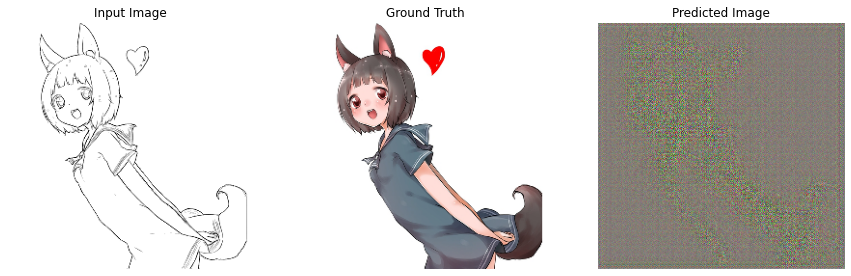

Epoch:  0
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

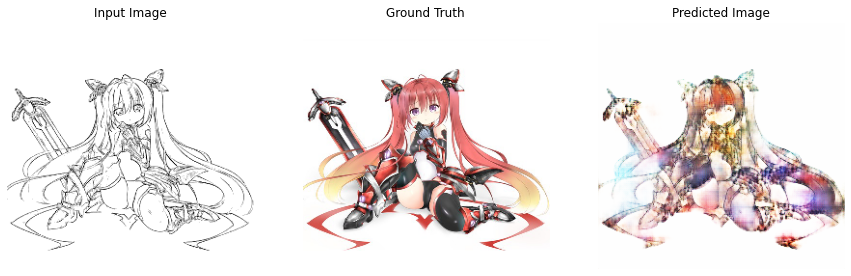

Epoch:  1
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

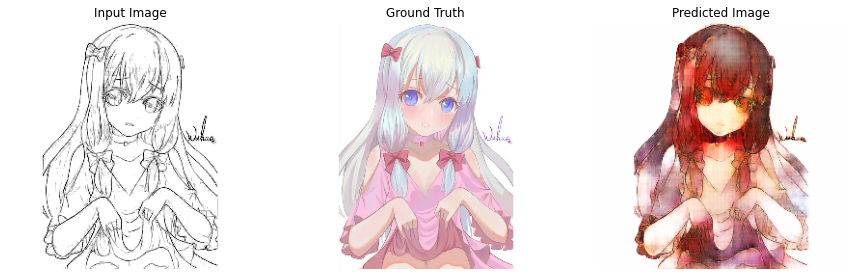

Epoch:  2
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

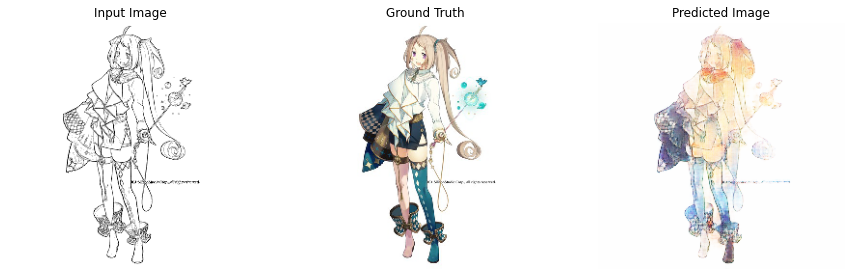

Epoch:  3
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

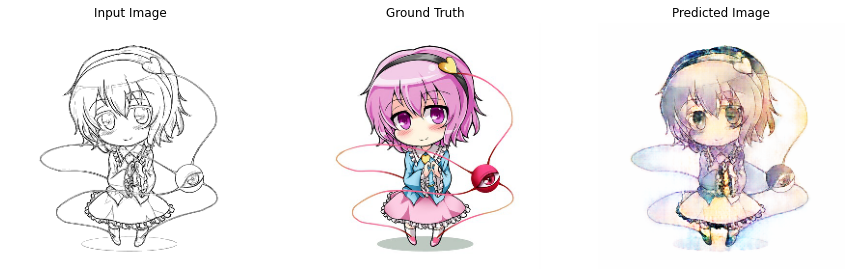

Epoch:  4
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

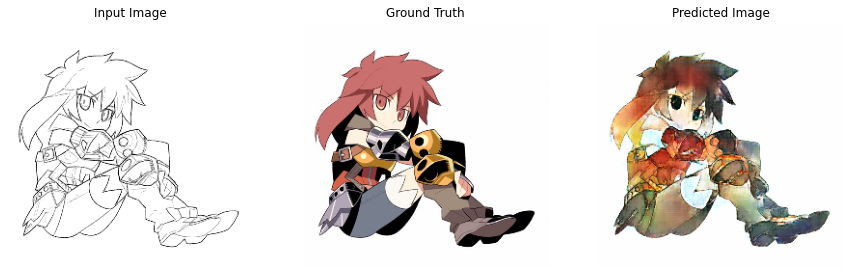

Epoch:  5
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

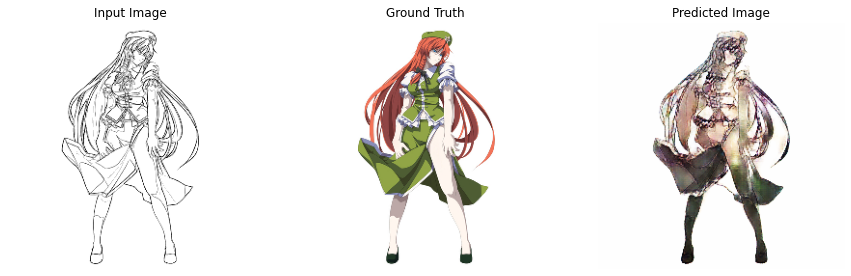

Epoch:  6
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

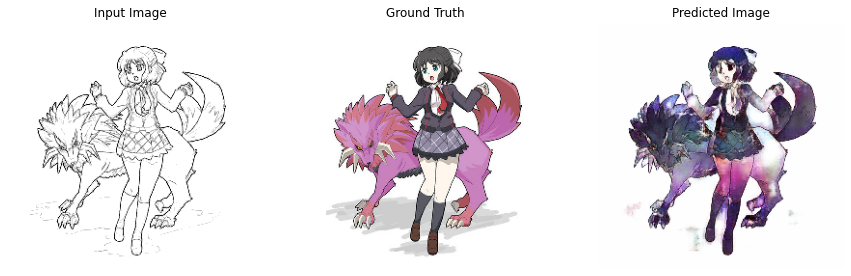

Epoch:  7
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

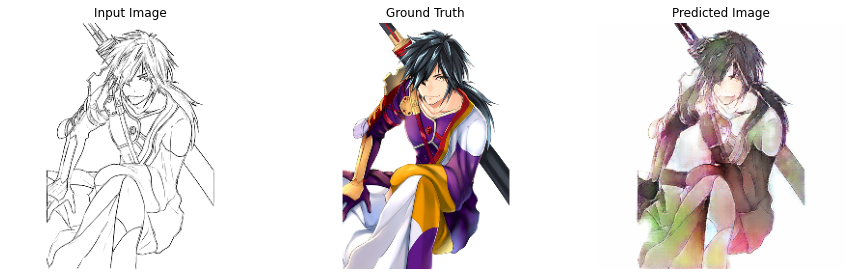

Epoch:  8
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

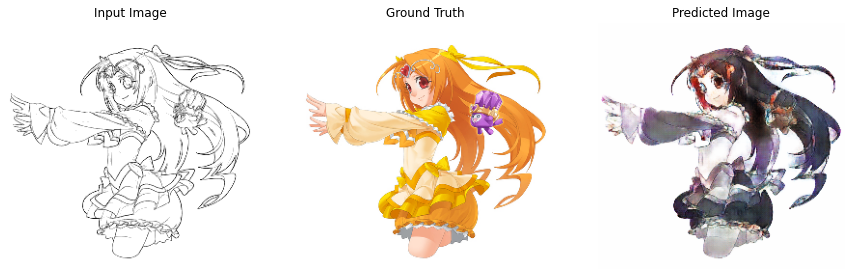

Epoch:  9
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

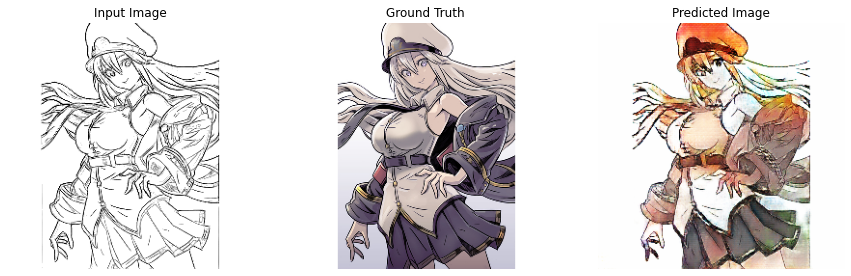

Epoch:  10
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

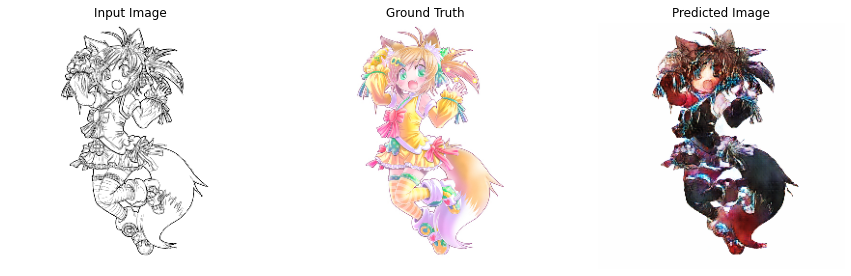

Epoch:  11
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

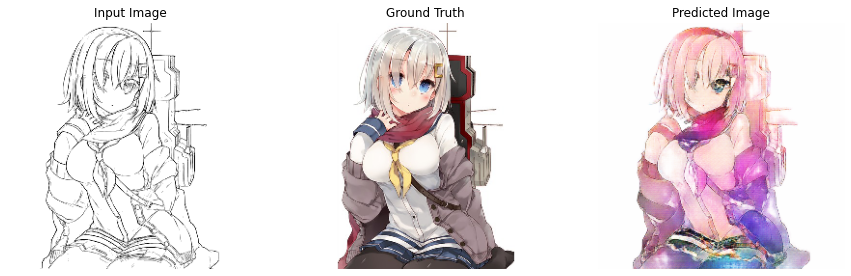

Epoch:  12
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

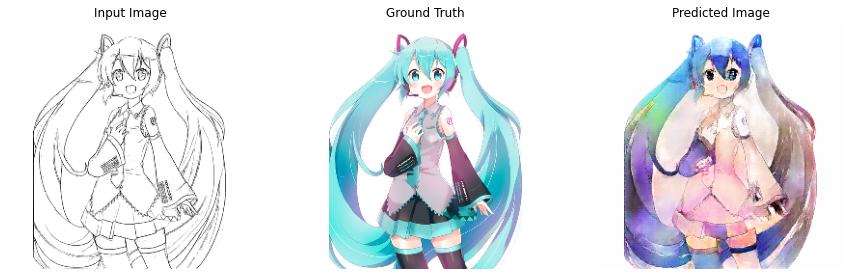

Epoch:  13
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

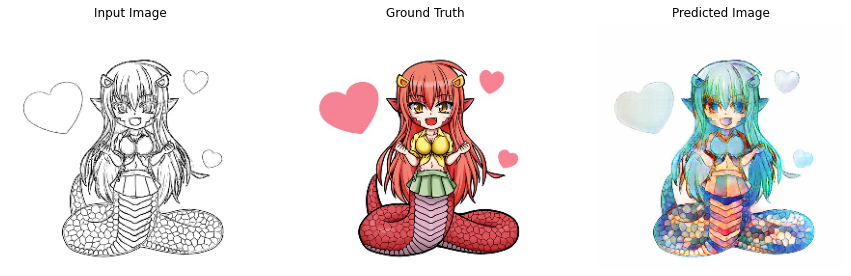

Epoch:  14
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [19]:
fit(train, 15, test)

In [22]:
generator.save('AnimeColorizationModelv1.h5')
!zip -r file.zip './'

  adding: AnimeColorizationModelv1.h5 (deflated 7%)
  adding: __notebook_source__.ipynb (deflated 44%)
  adding: Sketch2Color_training_checkpoints/ (stored 0%)
  adding: Sketch2Color_training_checkpoints/checkpoint (deflated 38%)
  adding: Sketch2Color_training_checkpoints/ckpt-2.data-00000-of-00001 (deflated 15%)
  adding: Sketch2Color_training_checkpoints/ckpt-1.data-00000-of-00001 (deflated 15%)
  adding: Sketch2Color_training_checkpoints/ckpt-1.index (deflated 79%)
  adding: Sketch2Color_training_checkpoints/ckpt-3.index (deflated 79%)
  adding: Sketch2Color_training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 15%)
  adding: Sketch2Color_training_checkpoints/ckpt-2.index (deflated 79%)
  adding: Sketch2Color_training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 15%)
  adding: Sketch2Color_training_checkpoints/ckpt-4.index (deflated 79%)
  adding: Sketch2Coloe_logs/ (stored 0%)
  adding: Sketch2Coloe_logs/fit/ (stored 0%)
  adding: Sketch2Coloe_logs/fit/20210718-081316/ (st

In [23]:
from IPython.display import FileLink
FileLink('./file.zip')

/kaggle/working/file.zip